In [9]:
%matplotlib inline
import numpy as np
import os

from datavyz import graph_env_dark_notebook as ge

In [10]:
# LOCs = np.load('data/nmda-spike/locations.npy') ---> corresponds to:
LOCs = [74, 124, 313, 363, 474, 630, 680, 800, 886, 936, 1036, 1227, 1428, 1478, 1634, 1856, 2117, 2183, 2233, 2379, 2429, 3177, 3319, 3464, 3514]

In [11]:
from single_cell_sim import *
from model import Model

def run_sim(Model,
            syn_packets=[{'loc':0, 'nsyn':5, 'label':'1'},
                         {'loc':1, 'nsyn':5, 'label':'2'}],
            activation_sequence=[{'time':200,
                                  'packet':0},
                                 {'time':400,
                                  'packet':1}],
            syn_packet_width=5,
            Nsyn_per_loc=20,
            post_duration=200.,
            stim_seed=2,
            active=False,
            ampa_only=False,
            chelated=False):


    Modelc = Model.copy()
    tstop = activation_sequence[-1]['time']+post_duration
    if chelated:
        Modelc['alphaZn'] = 0.

    t, neuron, SEGMENTS = initialize_sim(Model,
                                         active=active,
                                         tstop=tstop, verbose=False)

    np.random.seed(stim_seed)
    
    PACKETS, ulocs = [], np.unique([sp['loc'] for sp in syn_packets])
    for i, sp in enumerate(syn_packets):
        i0 = np.argwhere(sp['loc']==ulocs).flatten()[0] # to catch syn packets at the same location
        locs = LOCs[sp['loc']]+np.arange(Nsyn_per_loc)
        times = np.sort(np.random.randn(sp['nsyn'])*syn_packet_width)
        IDs = np.random.choice(i0*Nsyn_per_loc+np.arange(Nsyn_per_loc), sp['nsyn'], replace=False)
        labels = [sp['label'] for i in range(sp['nsyn'])]
        PACKETS.append({'times':times, 'IDs':IDs, 'locs':locs, 'labels':labels})
        
    syn_IDs, syn_times, syn_labels = np.empty(0, dtype=int), np.empty(0, dtype=float), np.empty(0, dtype=str)

    for i, act in enumerate(activation_sequence):
        syn_times = np.concatenate([syn_times,
                                    act['time']+PACKETS[act['packet']]['times']])
        syn_IDs = np.concatenate([syn_IDs,
                                  PACKETS[act['packet']]['IDs']])
        syn_labels = np.concatenate([syn_labels, PACKETS[act['packet']]['labels']])

    if ampa_only:
        Modelc['qNMDA'] = 0.
    elif chelated:
        Modelc['Deltax0'] = 0.
        
    Estim, ES = ntwk.process_and_connect_event_stimulation(neuron,
                                                           syn_IDs, syn_times,
                                                           np.concatenate([(LOCs[ul]+np.arange(Nsyn_per_loc)) for ul in ulocs]),
                                                           EXC_SYNAPSES_EQUATIONS.format(**Modelc),
                                                           ON_EXC_EVENT.format(**Modelc))

    # recording and running
    M = ntwk.StateMonitor(neuron, ('v'), record=[0]+[sp['loc'] for sp in syn_packets])
    S = ntwk.StateMonitor(ES, ('X', 'gAMPA', 'gRiseNMDA', 'gDecayNMDA', 'bZn'), record=[0])

    # # Run simulation
    ntwk.run(tstop*ntwk.ms)
    
    data = {'t':np.array(M.t/ntwk.ms), 
            'Vm_soma':np.array(M.v/ntwk.mV)[0,:],
            'bZn_syn':np.array(S.bZn)[0,:],
            'gAMPA_syn':np.array(S.gAMPA/ntwk.nS)[0,:],
            'X_syn':np.array(S.X)[0,:],
            'Vm_syn':np.array(M.v/ntwk.mV)[1,:],
            'syn_times': syn_times,
            'syn_IDs': syn_IDs,
            'syn_labels': syn_labels,
            'Model':Modelc}
    data['gNMDA_syn']= Model['qNMDA']*Model['nNMDA']*\
        (np.array(S.gDecayNMDA)[0,:]-np.array(S.gRiseNMDA)[0,:])\
        /(1+Model['etaMg']*Model['cMg']*np.exp(-data['Vm_syn']/Model['V0NMDA']))\
        *(1-Model['alphaZn']*data['bZn_syn'])
    
    for obj in [neuron, M, S, Estim, ES, SEGMENTS]:
        del(obj)
        
    return data

def build_fig(list_data_freeZn, list_data_chelatedZn, list_data_AMPA,
              list_data_freeZn_active=None, list_data_chelatedZn_active=None,
              space=50, Nsyn_bar=10, Tbar=20, Vlim=[-75,-30]):
    # fig shape
    fig, AX = ge.figure(axes_extents=[[[1,2]],
                                      [[3,5]]], 
                        #figsize=(2.,.15), 
                        figsize=(4.,.3), 
                        hspace=0)

    t0=0
    for data_freeZn, data_chelatedZn, data_AMPA in zip(list_data_freeZn, list_data_chelatedZn, list_data_AMPA):
        n=0
        for label, color in zip(['1', '2', '3', '4'], [ge.cyan, ge.pink, ge.purple, ge.orange]):
            cond = (data_freeZn['syn_labels']==label)
            AX[0].plot(t0+data_freeZn['syn_times'][cond], n+data_freeZn['syn_IDs'][cond], 'o', ms=1, color=color)
            if np.sum(cond)>0:
                n+=np.max(data_freeZn['syn_IDs'][cond])
            
        if data_chelatedZn is not None:
            AX[1].plot(t0+data_chelatedZn['t'], data_chelatedZn['Vm_soma'], color=ge.green, lw=1)
        if data_AMPA is not None:
            AX[1].plot(t0+data_AMPA['t'], data_AMPA['Vm_soma'], color=ge.blue, lw=1)
        AX[1].plot(t0+data_freeZn['t'], data_freeZn['Vm_soma'], color='k', lw=1)
        t0 += data_freeZn['t'][-1]+space
        
    ge.set_plot(AX[0], [], xlim=[0, t0], ylim=[-2, AX[0].get_ylim()[1]+2])
    ge.set_plot(AX[1], [], xlim=[0, t0], ylim=Vlim)
    ge.draw_bar_scales(AX[0], Xbar=Tbar, Xbar_label='%ims' % Tbar, Ybar=Nsyn_bar, Ybar_label='%i syn.' % Nsyn_bar,
                       xyLoc=(0,AX[0].get_ylim()[1]))
    ge.draw_bar_scales(AX[1], Xbar=1e-10, Xbar_label='', Ybar=10, Ybar_label='10mV ', xyLoc=(0,-50))
    ge.annotate(AX[1], '\n\n  AMPA only', (1,.9), va='top', color=ge.blue)
    ge.annotate(AX[1], '\n  free Zinc', (1,.9), va='top')
    ge.annotate(AX[1], '  chelated Zinc', (1,.9), va='top', color=ge.green)
    ge.annotate(AX[1], '-75mV  -> ', (0,-75), va='center', ha='right', xycoords='data')


## Illustrate on an example location

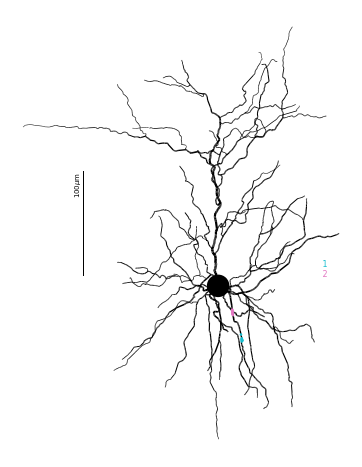

In [16]:
iloc0 = 0
loc_syn1, loc_syn2 = LOCs[iloc0], LOCs[iloc0]-40

from datavyz import nrnvyz
_, neuron, SEGMENTS = initialize_sim(Model)
vis = nrnvyz(SEGMENTS, ge=ge)
        
#fig, ax = ge.figure(figsize=(1.2,1.8), wspace=0, left=0, top=0.3, bottom=0, right=0)
fig1, ax = ge.figure(figsize=(10,10), wspace=0, left=0, top=0.3, bottom=0, right=0)


ax.plot([-130, -130], [10, 110], 'k-', lw=1)
ge.annotate(ax, '100$\mu$m', (-130, 110), va='top', ha='right', rotation=90, xycoords='data', size='small')
vis.plot_segments(SEGMENTS['comp_type']!='axon',
                  bar_scale_args=None,
                  ax=ax)
vis.add_dots(ax, loc_syn1+np.arange(10), 7, ge.cyan)
vis.add_dots(ax, loc_syn2+np.arange(10), 7, ge.pink)
ge.annotate(ax, ' 1\n', (.9,0.4), va='bottom', ha='left', color=ge.cyan)
ge.annotate(ax, ' 2', (.9,0.4), va='bottom', ha='left', color=ge.pink)

del(neuron)
del(SEGMENTS)
del(_)
#ge.save_on_desktop(fig, 'panel1.svg')

## Passive sim

In [10]:
NSYN = 10

iloc0 = 6
LOCs.append(LOCs[iloc0]+20)

syn_packets=[{'loc':iloc0, 'nsyn':NSYN, 'label':'1'},
             {'loc':len(LOCs)-1, 'nsyn':NSYN, 'label':'2'}]


data_freeZn_single_stim1 = run_sim(Model, syn_packets=syn_packets, Nsyn_per_loc=NSYN,
                                   activation_sequence=[{'time':50, 'packet':0}],
                                   
                                   chelated=False, active=False)
data_freeZn_single_stim2 = run_sim(Model, syn_packets=syn_packets, Nsyn_per_loc=NSYN,
                                   activation_sequence=[{'time':50, 'packet':1}],
                                   chelated=False, active=False)

data_freeZn_double_stim11 = run_sim(Model, syn_packets=syn_packets, Nsyn_per_loc=NSYN, 
                                   activation_sequence=[{'time':50, 'packet':0}, {'time':100, 'packet':0}],
                                   chelated=False, active=False)

data_freeZn_double_stim22 = run_sim(Model, syn_packets=syn_packets, Nsyn_per_loc=NSYN, 
                                   activation_sequence=[{'time':50, 'packet':1}, {'time':100, 'packet':1}],
                                   chelated=False, active=False)

data_freeZn_double_stim12 = run_sim(Model, syn_packets=syn_packets, Nsyn_per_loc=NSYN, 
                                   activation_sequence=[{'time':50, 'packet':0}, {'time':100, 'packet':1}],
                                   chelated=False, active=False)

data_freeZn_double_stim21 = run_sim(Model, syn_packets=syn_packets, Nsyn_per_loc=NSYN, 
                                   activation_sequence=[{'time':50, 'packet':1}, {'time':100, 'packet':0}],
                                   chelated=False, active=False)

# -----

data_AMPA_single_stim1 = run_sim(Model, syn_packets=syn_packets, Nsyn_per_loc=NSYN, 
                                   activation_sequence=[{'time':50, 'packet':0}],
                                   ampa_only=True)
data_AMPA_single_stim2 = run_sim(Model, syn_packets=syn_packets, Nsyn_per_loc=NSYN, 
                                   activation_sequence=[{'time':50, 'packet':1}],
                                   ampa_only=True)

data_AMPA_double_stim11 = run_sim(Model, syn_packets=syn_packets, Nsyn_per_loc=NSYN, 
                                   activation_sequence=[{'time':50, 'packet':0}, {'time':100, 'packet':0}],
                                   ampa_only=True)

data_AMPA_double_stim22 = run_sim(Model, syn_packets=syn_packets, Nsyn_per_loc=NSYN, 
                                   activation_sequence=[{'time':50, 'packet':1}, {'time':100, 'packet':1}],
                                   ampa_only=True)

data_AMPA_double_stim12 = run_sim(Model, syn_packets=syn_packets, Nsyn_per_loc=NSYN, 
                                   activation_sequence=[{'time':50, 'packet':0}, {'time':100, 'packet':1}],
                                   ampa_only=True)

data_AMPA_double_stim21 = run_sim(Model, syn_packets=syn_packets, Nsyn_per_loc=NSYN, 
                                   activation_sequence=[{'time':50, 'packet':1}, {'time':100, 'packet':0}],
                                   ampa_only=True)
    
# -----

data_chelatedZn_double_stim11 = run_sim(Model, syn_packets=syn_packets, Nsyn_per_loc=NSYN, 
                                   activation_sequence=[{'time':50, 'packet':0}, {'time':100, 'packet':0}],
                                   chelated=True, active=False)

data_chelatedZn_double_stim22 = run_sim(Model, syn_packets=syn_packets, Nsyn_per_loc=NSYN, 
                                   activation_sequence=[{'time':50, 'packet':1}, {'time':100, 'packet':1}],
                                   chelated=True, active=False)


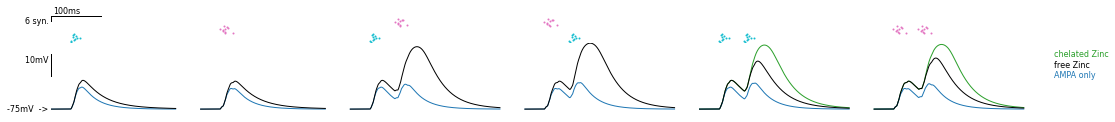

In [11]:

list_data_freeZn = [data_freeZn_single_stim1, data_freeZn_single_stim2,
                    data_freeZn_double_stim12,data_freeZn_double_stim21,
                    data_freeZn_double_stim11,data_freeZn_double_stim22]

list_data_AMPA = [data_AMPA_single_stim1, data_AMPA_single_stim2,
                    data_AMPA_double_stim12,data_AMPA_double_stim21,
                    data_AMPA_double_stim11,data_AMPA_double_stim22]

list_data_chelatedZn = [None for i in range(4)]+\
                       [data_chelatedZn_double_stim11, data_chelatedZn_double_stim22]

build_fig(list_data_freeZn, list_data_chelatedZn, list_data_AMPA, Tbar=100, Vlim=[-76,-45], Nsyn_bar=6)

## Active sims

In [12]:
active = True

data_Act_freeZn_double_stim11 = run_sim(Model, syn_packets=syn_packets, 
                                   activation_sequence=[{'time':50, 'packet':0}, {'time':100, 'packet':0}],
                                   chelated=False, active=active)

data_Act_freeZn_double_stim22 = run_sim(Model, syn_packets=syn_packets, 
                                   activation_sequence=[{'time':50, 'packet':1}, {'time':100, 'packet':1}],
                                   chelated=False, active=active)

data_Act_freeZn_double_stim12 = run_sim(Model, syn_packets=syn_packets, 
                                   activation_sequence=[{'time':50, 'packet':0}, {'time':100, 'packet':1}],
                                   chelated=False, active=active)

data_Act_freeZn_double_stim21 = run_sim(Model, syn_packets=syn_packets, 
                                   activation_sequence=[{'time':50, 'packet':1}, {'time':100, 'packet':0}],
                                   chelated=False, active=active)

data_Act_chelatedZn_double_stim11 = run_sim(Model, syn_packets=syn_packets, 
                                   activation_sequence=[{'time':50, 'packet':0}, {'time':100, 'packet':0}],
                                   chelated=True, active=active)

data_Act_chelatedZn_double_stim22 = run_sim(Model, syn_packets=syn_packets, 
                                   activation_sequence=[{'time':50, 'packet':1}, {'time':100, 'packet':1}],
                                   chelated=True, active=active)

KeyboardInterrupt: 

In [ ]:
list_data_freeZn = [data_Act_freeZn_double_stim12,data_Act_freeZn_double_stim21,
                    data_Act_freeZn_double_stim11,data_Act_freeZn_double_stim22]
list_data_chelatedZn = [data_Act_freeZn_double_stim12,data_Act_freeZn_double_stim21,\
                       data_Act_chelatedZn_double_stim11, data_Act_chelatedZn_double_stim22]
build_fig(list_data_freeZn, list_data_chelatedZn, [None for i in range(4)], Tbar=100, Vlim=[-80,15])

### merge in fig

In [ ]:
list_data_freeZn = [data_freeZn_single_stim1, data_freeZn_single_stim2,
                    data_freeZn_double_stim12,data_freeZn_double_stim21,
                    data_freeZn_double_stim11,data_freeZn_double_stim22]

list_data_AMPA = [data_AMPA_single_stim1, data_AMPA_single_stim2,
                    data_AMPA_double_stim12,data_AMPA_double_stim21,
                    data_AMPA_double_stim11,data_AMPA_double_stim22]

list_data_chelatedZn = [data_freeZn_single_stim1, data_freeZn_single_stim2,
                        data_freeZn_double_stim12,data_freeZn_double_stim21,
                        data_chelatedZn_double_stim11, data_chelatedZn_double_stim22]


list_data_Act_freeZn = [data_Act_freeZn_double_stim12,data_Act_freeZn_double_stim21,
                        data_Act_freeZn_double_stim11,data_Act_freeZn_double_stim22]

list_data_Act_chelatedZn = [None for i in range(2)]+\
                       [data_Act_chelatedZn_double_stim11, data_Act_chelatedZn_double_stim22]

space=50
Nsyn_bar=10
Tbar=50
Vlim=[-77,-30]

fig, AX = ge.figure(axes_extents=[[[1,2]],
                                  [[3,5]]], 
                    figsize=(2.,.15), 
                    #figsize=(3.,.3), 
                    hspace=0)

t0=0
for data_freeZn, data_chelatedZn, data_AMPA in zip(list_data_freeZn, list_data_chelatedZn, list_data_AMPA):
    n=0
    for label, color in zip(['1', '2', '3', '4'], [ge.cyan, ge.pink, ge.purple, ge.orange]):
        cond = (data_freeZn['syn_labels']==label)
        AX[0].plot(t0+data_freeZn['syn_times'][cond], n+data_freeZn['syn_IDs'][cond], 'o', ms=.5, color=color)
        if np.sum(cond)>0:
            n+=np.max(data_freeZn['syn_IDs'][cond])

    if data_AMPA is not None:
        AX[1].plot(t0+data_AMPA['t'], data_AMPA['Vm_soma'], color=ge.blue, lw=1)
    AX[1].plot(t0+data_freeZn['t'], data_freeZn['Vm_soma'], color='k', lw=1)
    if data_chelatedZn is not None:
        AX[1].plot(t0+data_chelatedZn['t'], data_chelatedZn['Vm_soma'], '--', color=ge.green, lw=0.5)
    t0 += data_freeZn['t'][-1]+space

for i in range(4):
    axi = ge.inset(AX[1], [0.4+i*0.17, .5, .05, .5])
    data_freeZn, data_chelatedZn = list_data_Act_freeZn[i], list_data_Act_chelatedZn[i]
    if data_chelatedZn is not None:
        axi.plot(t0+data_chelatedZn['t'], data_chelatedZn['Vm_soma'], '--', color=ge.green, lw=0.5)
        axi.plot(t0+data_freeZn['t'], data_freeZn['Vm_soma'], color='k', lw=1)
    else:
        axi.plot(t0+data_freeZn['t'], data_freeZn['Vm_soma'], color='k', lw=1)        
        axi.plot(t0+data_freeZn['t'], data_freeZn['Vm_soma'], '--', color=ge.green, lw=0.5)
    ge.set_plot(axi, [], ylim=[-82, 10])
    
ge.draw_bar_scales(axi, Xbar=1e-3, Xbar_label=' ', Ybar=30, Ybar_label=' 30mV', loc='top-right')
    
ge.set_plot(AX[0], [], xlim=[0, t0], ylim=[-2, AX[0].get_ylim()[1]+2])
ge.set_plot(AX[1], [], xlim=[0, t0], ylim=Vlim)
ge.draw_bar_scales(AX[0], Xbar=Tbar, Xbar_label='%ims' % Tbar, Ybar=Nsyn_bar, Ybar_label='%i syn.' % Nsyn_bar,
                   xyLoc=(0,AX[0].get_ylim()[1]))
ge.draw_bar_scales(AX[1], Xbar=1e-10, Xbar_label='', Ybar=10, Ybar_label='10mV ', xyLoc=(0,-50))
ge.annotate(AX[1], '\n\n  AMPA only', (1,.5), va='top', color=ge.blue, size='small')
ge.annotate(AX[1], '\n  free Zinc', (1,.5), va='top', size='small')
ge.annotate(AX[1], '  chelated Zinc', (1,.5), va='top', color=ge.green, size='small')
ge.annotate(AX[1], '-75mV - ', (0,-75), va='center', ha='right', xycoords='data', size='small')
ge.annotate(AX[0], 'pattern 1', (0.04,0.5), size='x-small', color=ge.cyan)
ge.annotate(AX[0], 'pattern 2', (0.18,0.), size='x-small', color=ge.pink)

ge.save_on_desktop(fig, 'panel2.svg')

## Scan parameter space: intensity x timing

In [10]:
interstims = np.logspace(np.log10(30), np.log10(400), 18)
nsyns = 5+np.arange(18)

print('interstims (ms): ', interstims)
print('nsyns: (ms)', nsyns)

interstims (ms):  [ 30.          34.93768473  40.68806049  47.38488766  55.1839422
  64.26663917  74.8442526   87.16283005 101.5089159  118.21621671
 137.67336366 160.33295253 186.7220716  217.45456234 253.2452981
 294.92681285 343.4686669  400.        ]
nsyns: (ms) [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


In [80]:
iloc = 6
active = False

delta_Vm = np.zeros((len(interstims), len(nsyns)))

for i, DT in enumerate(interstims):
    for j, nsyn in enumerate(nsyns):
        syn_packets=[{'loc':iloc, 'nsyn':nsyn, 'label':'1'}]

        data_freeZn = run_sim(Model, syn_packets=syn_packets, Nsyn_per_loc=nsyn,
                                  activation_sequence=[{'time':20, 'packet':0}, {'time':20+DT, 'packet':0}],
                                  chelated=False, active=active)
        data_chelatedZn = run_sim(Model, syn_packets=syn_packets, Nsyn_per_loc=nsyn,
                                  activation_sequence=[{'time':20, 'packet':0}, {'time':20+DT, 'packet':0}],
                                  chelated=True, active=active)

        delta_Vm[i,j] = np.max(data_chelatedZn['Vm_soma'])-np.max(data_freeZn['Vm_soma'])

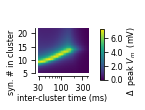

In [99]:
fig, ax = ge.figure(right=5.,
                    figsize=(.9,1.))
                    #figsize=(2,4))

ax.imshow(delta_Vm.T,
          interpolation=None, extent=[0, len(interstims), nsyns[0], nsyns[-1]],
          vmin = 0, vmax = np.max(delta_Vm), 
          origin='lower', aspect='auto')

# need to make a custom log axis corresponding to the log-spacing of interstim points
def dlog(x, n=len(interstims), x1=interstims[0], xn=interstims[-1]):
    return .5+(np.log10(x)-np.log10(x1))/(np.log10(xn)-np.log10(x1))*(n-1)
mticks = [dlog(x) for x in [30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400]]

ticks = [30, 100, 300]

ge.set_plot(ax,
            yticks=[5, 10, 15, 20], ylabel='syn. # in cluster         ',
            xminor_ticks=mticks,
            xticks=[dlog(x) for x in ticks], xticks_labels=['30 ', ' 100 ', ' 300'],
            xlabel='inter-cluster time (ms) ')

ge.bar_legend(fig,
              bounds=[0, np.max(delta_Vm)],
              ticks=[0, 2, 4, 6],
              ax_colorbar=None, 
              colorbar_inset=dict(rect=[.72,.3,.03,.5], facecolor=None),
              colormap=ge.viridis,
              label=r'$\Delta$  peak $V_m$  (mV)      ')

ge.save_on_desktop(fig, 'panel3.svg')
#ge.save_on_desktop(fig, 'panel3.png')

## population data on all locations

In [86]:
nlocs = len(LOCs)
delta_Vm = np.zeros((len(interstims), len(nsyns), nlocs))                     

## Parallelized over the available cores

In [ ]:
import multiprocessing as mp
import itertools, time

active = False

# interstims = np.logspace(np.log10(30), np.log10(400), 18)
# nsyns = 5+np.arange(18)
interstims = np.logspace(np.log10(30), np.log10(400), 10)
nsyns = 5+2*np.arange(10)
nlocs = 10 # len(LOCs)
delta_Vm = np.zeros((len(interstims), len(nsyns), nlocs))

def get_dVm(X):
    
    time.sleep(0.5)
    iDt, iNsyn, iloc = X # extract from array
    
    DT, nsyn = interstims[iDt], nsyns[iNsyn]
    #print('loc #%i, Nsyn=%i, dt=%.1f \n ' % (iloc+1, nsyn, DT))
    
    syn_packets=[{'loc':iloc, 'nsyn':nsyn, 'label':'1'}]

    data_freeZn = run_sim(Model, syn_packets=syn_packets, Nsyn_per_loc=nsyn,
                            activation_sequence=[{'time':20, 'packet':0}, {'time':20+DT, 'packet':0}],
                            chelated=False, active=active)
    data_chelatedZn = run_sim(Model, syn_packets=syn_packets, Nsyn_per_loc=nsyn,
                                activation_sequence=[{'time':20, 'packet':0}, {'time':20+DT, 'packet':0}],
                                chelated=True, active=active)
    return (np.max(data_chelatedZn['Vm_soma'])-np.max(data_freeZn['Vm_soma']))

n, P = 0, []
for iDt, iNsyn, iloc in itertools.product(range(len(interstims)), range(len(nsyns)), range(nlocs)):
    n+=1
    P.append((iDt, iNsyn, iloc,))
    if n%mp.cpu_count()==0:
        print('sim #%i/%i' % (n, len(interstims)*len(nsyns)*nlocs))
        # we do all simulations
        pool = mp.Pool(mp.cpu_count())
        result = pool.map(get_dVm, P)
        for p, r in zip(P, result):
            delta_Vm[p[0], p[1], p[2]] = r
        P = []
        
np.save('delta_Vm.npy', {'delta_Vm':delta_Vm, 'interstims':interstims, 'nsyns':nsyns})

delta peak Vm: 7.9 +/- 1.3 mV
wilcoxon : p=1.95e-03
syn. #: 10.2 +/- 1.8
interstim : 85.0 +/- 32.8 ms


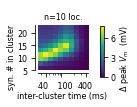

In [72]:
import numpy as np
from scipy.stats import wilcoxon

from datavyz import ge
data = np.load('delta_Vm.npy', allow_pickle=True).item()
nsyns, interstims, delta_Vm = data['nsyns'], data['interstims'], data['delta_Vm']

fig, ax = ge.figure(right=5.,
                    figsize=(.9,1.))
                    #figsize=(2,4))

ge.title(ax, 'n=%i loc.' % delta_Vm.shape[2])
ax.imshow(delta_Vm.mean(axis=-1).T,
          interpolation=None, extent=[0, len(interstims), nsyns[0], nsyns[-1]],
          vmin = 0, vmax = np.max(delta_Vm.mean(axis=-1)), 
          origin='lower', aspect='auto')

# need to make a custom log axis corresponding to the log-spacing of interstim points
def dlog(x, n=len(interstims), x1=interstims[0], xn=interstims[-1]):
    return .5+(np.log10(x)-np.log10(x1))/(np.log10(xn)-np.log10(x1))*(n-1)
mticks = [dlog(x) for x in [30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400]]

ticks = [40, 100, 400]

ge.set_plot(ax,# title='Zinc modulation',
            #xlim=[interstims[0], interstims[-1]], #xscale='log', 
            yticks=[5, 10, 15, 20], ylabel='syn. # in cluster       ',
            xminor_ticks=mticks,
            xticks=[dlog(x) for x in ticks], xticks_labels=['40  ', '   100', '400'],
            xlabel='inter-cluster time (ms) ')

ge.bar_legend(fig,
              bounds=[0, np.mean(delta_Vm.max(axis=(0,1)))],
              ticks=[0, 3, 6], ticks_labels=['0', '3', '6'],
              ax_colorbar=None, 
              colorbar_inset=dict(rect=[.72,.3,.03,.5], facecolor=None),
              colormap=ge.viridis,
              label=r'$\Delta$ peak $V_m$  (mV)      ')


print('delta peak Vm: %.1f +/- %.1f mV' % (delta_Vm.max(axis=(0,1)).mean(), delta_Vm.max(axis=(0,1)).std()))
print('wilcoxon : p=%.2e' % wilcoxon(delta_Vm.max(axis=(0,1))).pvalue)

NS, DT = [], []
x, y = np.meshgrid(nsyns, interstims, indexing='ij')
for i in range(delta_Vm.shape[2]):
    i0 = np.argmax(delta_Vm[:,:,i].flatten())
    NS.append(x.flatten()[i0])
    DT.append(y.flatten()[i0])

print('syn. #: %.1f +/- %.1f' % (np.mean(NS), np.std(NS)))
print('interstim : %.1f +/- %.1f ms' % (np.mean(DT), np.std(DT)))

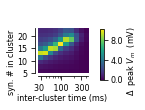

In [85]:
data = np.load('delta_Vm.npy', allow_pickle=True).item()
nsyns, interstims, delta_Vm = data['nsyns'], data['interstims'], data['delta_Vm'][:,:,0]

fig, ax = ge.figure(right=5.,
                    figsize=(.9,1.))
                    #figsize=(2,4))

ax.imshow(delta_Vm.T,
          interpolation=None, extent=[0, len(interstims), nsyns[0], nsyns[-1]],
          vmin = 0, vmax = np.max(delta_Vm), 
          origin='lower', aspect='auto')

# need to make a custom log axis corresponding to the log-spacing of interstim points
def dlog(x, n=len(interstims), x1=interstims[0], xn=interstims[-1]):
    return .5+(np.log10(x)-np.log10(x1))/(np.log10(xn)-np.log10(x1))*(n-1)
mticks = [dlog(x) for x in [30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400]]

ticks = [30, 100, 300]

ge.set_plot(ax,
            yticks=[5, 10, 15, 20], ylabel='syn. # in cluster         ',
            xminor_ticks=mticks,
            xticks=[dlog(x) for x in ticks], xticks_labels=['30 ', ' 100 ', ' 300'],
            xlabel='inter-cluster time (ms) ')

ge.bar_legend(fig,
              bounds=[0, np.max(delta_Vm)],
              ticks=[0, 4, 8],
              ax_colorbar=None, 
              colorbar_inset=dict(rect=[.72,.3,.03,.5], facecolor=None),
              colormap=ge.viridis,
              label=r'$\Delta$  peak $V_m$  (mV)      ')

In [50]:
delta_Vm.

1.3385777532584922

(20, 18, 26)


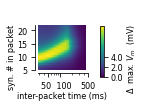

In [15]:
data = np.load('delta_Vm.npy', allow_pickle=True).item()
#nsyns, interstims, delta_Vm = data['nsyns'], data['interstims'], data['delta_Vm']

print(delta_Vm.shape)
fig, ax = ge.figure(right=5.,
                    figsize=(.9,1.))
                    #figsize=(2,4))

ax.imshow(delta_Vm.mean(axis=-1).T,
          interpolation=None, extent=[0, len(interstims), nsyns[0], nsyns[-1]],
          vmin = 0, vmax = np.max(delta_Vm.mean(axis=-1)), 
          origin='lower', aspect='auto')

# need to make a custom log axis corresponding to the log-spacing of interstim points
def dlog(x, n=len(interstims), x1=interstims[0], xn=interstims[-1]):
    return .5+(np.log10(x)-np.log10(x1))/(np.log10(xn)-np.log10(x1))*(n-1)
mticks = [dlog(x) for x in [30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500]]

ticks = [50, 100, 500]

ge.set_plot(ax,# title='Zinc modulation',
            #xlim=[interstims[0], interstims[-1]], #xscale='log', 
            yticks=[5, 10, 15, 20], ylabel='syn. # in packet       ',
            xminor_ticks=mticks,
            xticks=[dlog(x) for x in ticks], xticks_labels=['50  ', '   100', '500'],
            xlabel='inter-packet time (ms) ')

ge.bar_legend(fig,
              bounds=[0, np.max(delta_Vm)],
              ticks=[0, 2, 4],
              ax_colorbar=None, 
              colorbar_inset=dict(rect=[.72,.3,.03,.5], facecolor=None),
              colormap=ge.viridis,
              label=r'$\Delta$  max. $V_m$  (mV)      ')

ge.save_on_desktop(fig, 'panel3.svg')